In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
df_complete = pd.read_csv('../data/data_complete.csv')
df_mean = pd.read_csv('../data/data_mean.csv', index_col=0)
df_ml = pd.read_csv('../data/data_ml.csv', index_col=0)
df_mice = pd.read_csv('../data/data_mice.csv')

In [4]:
sum(df_mice.isna().any())

0

In [305]:
sum(df_mean.isna().any())

0

In [306]:
sum(df_ml.isna().any())

0

In [8]:
len(df_mice.columns)

93

In [10]:
df_complete

,Age,County,Gravida,Para,Episiotomy,Laceration.Extension,Amniotic.Fluid.Color,Attempt.to.Vbac,Csection.Incidence,Csection.Urgency,...,reason_for_admission_ROM,reason_for_admission_Observe,reason_for_admission_other,race_black,race_white,race_pacific_islander,race_asian,race_arabic,race_american_indian,race_other
0,25,knox,3,2,None,Second,clear,No,NAnone,NAnone,...,False,False,False,False,False,False,False,False,False,True
1,33,knox,6,5,None,NAnone,bloody,NAnone,NAnone,NAnone,...,False,True,False,True,False,False,False,False,False,False
2,34,knox,1,0,None,NAnone,heavy meconium,NAnone,Primary,Nonemer,...,False,False,False,False,True,False,False,False,False,False
3,28,loudon,3,1,None,NAnone,moderate meconium,NAnone,NAnone,NAnone,...,False,False,False,False,True,False,False,False,False,False
4,31,blount,2,1,None,Second,clear,NAnone,NAnone,NAnone,...,True,True,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,21,cocke,2,1,None,NAnone,clear,NAnone,NAnone,NAnone,...,False,False,False,False,True,False,False,False,False,False
3136,21,knox,2,0,None,NAnone,bloody,No,NAnone,NAnone,...,False,False,False,True,False,False,False,False,False,False
3137,34,knox,4,1,None,First,clear,NAnone,NAnone,NAnone,...,True,False,False,False,True,False,False,False,False,False
3138,34,knox,4,3,None,NAnone,clear,NAnone,NAnone,NAnone,...,False,False,False,False,True,False,False,False,False,False


In [11]:
len(df_mean.columns)

93

In [4]:
# delete the scheduled samples
df_complete = df_complete[df_complete['Csection.Urgency'] != 'Schedule']
df_mean = df_mean[df_mean['Csection.Urgency'] != 'Schedule']
df_ml = df_ml[df_ml['Csection.Urgency'] != 'Schedule']
df_mice = df_mice[df_mice['Csection.Urgency'] != 'Schedule']

In [5]:
print(df_complete['Csection.Urgency'].value_counts())
print(df_mean['Csection.Urgency'].value_counts())
print(df_ml['Csection.Urgency'].value_counts())
print(df_mice['Csection.Urgency'].value_counts())

NAnone      3050
Nonemer       83
Emergent       5
Name: Csection.Urgency, dtype: int64
NAnone      12334
Nonemer      2572
Emergent      500
Name: Csection.Urgency, dtype: int64
NAnone      12334
Nonemer      2572
Emergent      500
Name: Csection.Urgency, dtype: int64
NAnone      12334
Nonemer      2572
Emergent      500
Name: Csection.Urgency, dtype: int64


In [6]:
# delete Method.of.Delivery.A for predicting Csection.Urgency
del df_complete['Method.of.Delivery.A']
del df_mean['Method.of.Delivery.A']
del df_ml['Method.of.Delivery.A']
del df_mice['Method.of.Delivery.A'] 

In [7]:
# delete Method.of.Delivery.A for predicting Csection.Urgency
del df_complete['Csection.Incidence']
del df_mean['Csection.Incidence']
del df_ml['Csection.Incidence']
del df_mice['Csection.Incidence'] 

In [8]:
urgency_complete = df_complete.pop('Csection.Urgency')
urgency_mean = df_mean.pop('Csection.Urgency')
urgency_ml = df_ml.pop('Csection.Urgency')
urgency_mice = df_mice.pop('Csection.Urgency')

In [9]:
labels_complete=LabelEncoder().fit_transform(urgency_complete)
labels_mean=LabelEncoder().fit_transform(urgency_mean)
labels_ml=LabelEncoder().fit_transform(urgency_ml)
labels_mice=LabelEncoder().fit_transform(urgency_mice)

In [10]:
urgency_complete.value_counts()

NAnone      3050
Nonemer       83
Emergent       5
Name: Csection.Urgency, dtype: int64

In [11]:
print(Counter(labels_mice))

Counter({1: 12334, 2: 2572, 0: 500})


###  Model (use. LR to see which dataset has the best performance)

In [12]:
from functions import helpers
from functions import models
from functions import classifiers
from functions import metric

2024-07-12 16:51:06.170749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
features_complete = pd.get_dummies(df_complete)
features_mean = pd.get_dummies(df_mean)
features_ml = pd.get_dummies(df_ml)
features_mice = pd.get_dummies(df_mice)

### data : complete

In [32]:
X1_train, X1_test, y1_train, y1_test = helpers.split_and_scale_data(features_complete, labels_complete)

In [33]:
print(Counter(y1_train))

Counter({1: 2138, 2: 55, 0: 3})


In [34]:
print(Counter(y1_test))

Counter({1: 912, 2: 28, 0: 2})


In [35]:
X1_train.shape

(2196, 196)

In [36]:
X1_test.shape

(942, 196)

In [37]:
X1_train, y1_train = helpers.perform_SMOTE(X1_train, y1_train,k_neighbors=2)
print(Counter(y1_train))

Counter({1: 2138, 2: 2138, 0: 2138})


In [23]:
def run_Multinomial1(X_train_scaled, X_test_scaled, y_train, y_test):###872510-1992
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
    model.fit(X_train_scaled, y_train)
    # define the model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(model, X_train_scaled, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    # report the model performance
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    
    yhat = model.predict_proba(X_test_scaled)
    y_pred = model.predict(X_test_scaled)
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    # Generate detailed classification report
    report = classification_report(y_test, y_pred,output_dict=True)
    print("\nClassification Report:")
    print(report)
    
    
    # Calculate permutation importance
    result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    importances = result.importances_mean
    abs_importances = np.abs(importances)
    indices = np.argsort(abs_importances)[::-1][:20]
    top_20_features = [X_test_scaled.columns[i] for i in indices]
    top_20_importances = importances[indices]
    # Plot the top 20 features and their importance
    plt.figure(figsize=(10, 6))
    plt.barh(top_20_features, top_20_importances, color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
    plt.show()
   

    return model,report, importances,top_20_features

/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Mean Accuracy: 0.998 (0.002)
Confusion Matrix:
[[  0   0   2]
 [  0 908   4]
 [  0   4  24]]

Classification Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, '1': {'precision': 0.9956140350877193, 'recall': 0.9956140350877193, 'f1-score': 0.9956140350877193, 'support': 912}, '2': {'precision': 0.8, 'recall': 0.8571428571428571, 'f1-score': 0.8275862068965518, 'support': 28}, 'accuracy': 0.9893842887473461, 'macro avg': {'precision': 0.5985380116959065, 'recall': 0.6175856307435255, 'f1-score': 0.6077334139947571, 'support': 942}, 'weighted avg': {'precision': 0.9876857749469214, 'recall': 0.9893842887473461, 'f1-score': 0.9885057471264368, 'support': 942}}


/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


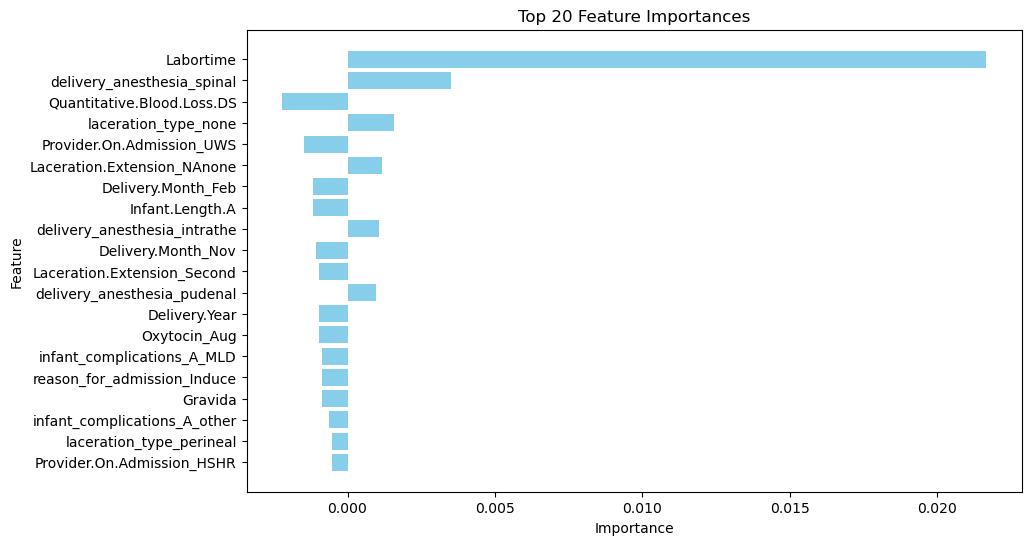

In [46]:
model1,importance1,features_i1,top_features_complete = models.run_Multinomial1(X1_train, X1_test, y1_train, y1_test)

### data : mean

In [41]:
X2_train, X2_test, y2_train, y2_test = helpers.split_and_scale_data(features_mean, labels_mean)

In [42]:
print(Counter(y2_train))

Counter({1: 8608, 2: 1815, 0: 361})


In [43]:
print(Counter(y2_test))

Counter({1: 3726, 2: 757, 0: 139})


In [44]:
X2_train, y2_train = helpers.perform_SMOTE(X2_train, y2_train)
print(Counter(y2_train))

Counter({1: 8608, 2: 8608, 0: 8608})


/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Mean Accuracy: 0.898 (0.008)
Confusion Matrix:
[[  89    9   41]
 [  52 3577   97]
 [ 154   36  567]]

Classification Report:
{'0': {'precision': 0.3016949152542373, 'recall': 0.6402877697841727, 'f1-score': 0.4101382488479263, 'support': 139}, '1': {'precision': 0.9875759249033683, 'recall': 0.9600107353730543, 'f1-score': 0.9735982580293957, 'support': 3726}, '2': {'precision': 0.8042553191489362, 'recall': 0.7490092470277411, 'f1-score': 0.7756497948016415, 'support': 757}, 'accuracy': 0.915837299870186, 'macro avg': {'precision': 0.6978420531021806, 'recall': 0.783102584061656, 'f1-score': 0.7197954338929878, 'support': 4622}, 'weighted avg': {'precision': 0.9369244409359657, 'recall': 0.915837299870186, 'f1-score': 0.9242326310411582, 'support': 4622}}


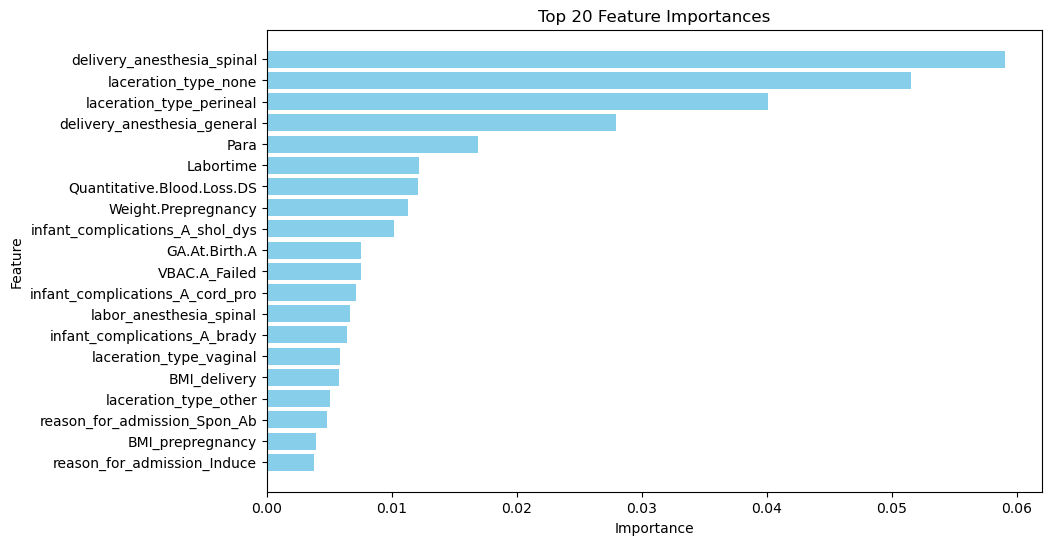

In [47]:
model2,importance2,features_i2,top_features_mean = models.run_Multinomial1(X2_train, X2_test, y2_train, y2_test)

### data:ml

In [48]:
X_train, X_test, y_train, y_test = helpers.split_and_scale_data(features_ml, labels_ml)

In [49]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 8608, 2: 1815, 0: 361})
Counter({1: 3726, 2: 757, 0: 139})


In [50]:
X_train, y_train = helpers.perform_SMOTE(X_train, y_train)
print(Counter(y_train))

Counter({1: 8608, 2: 8608, 0: 8608})


/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Mean Accuracy: 0.899 (0.007)
Confusion Matrix:
[[  90    9   40]
 [  50 3577   99]
 [ 149   38  570]]

Classification Report:
{'0': {'precision': 0.31141868512110726, 'recall': 0.6474820143884892, 'f1-score': 0.4205607476635514, 'support': 139}, '1': {'precision': 0.9870309050772627, 'recall': 0.9600107353730543, 'f1-score': 0.9733333333333334, 'support': 3726}, '2': {'precision': 0.8039492242595204, 'recall': 0.7529722589167768, 'f1-score': 0.7776261937244201, 'support': 757}, 'accuracy': 0.9167027260926006, 'macro avg': {'precision': 0.7007996048192968, 'recall': 0.7868216695594401, 'f1-score': 0.7238400915737683, 'support': 4622}, 'weighted avg': {'precision': 0.9367273717685356, 'recall': 0.9167027260926006, 'f1-score': 0.9246562034994852, 'support': 4622}}


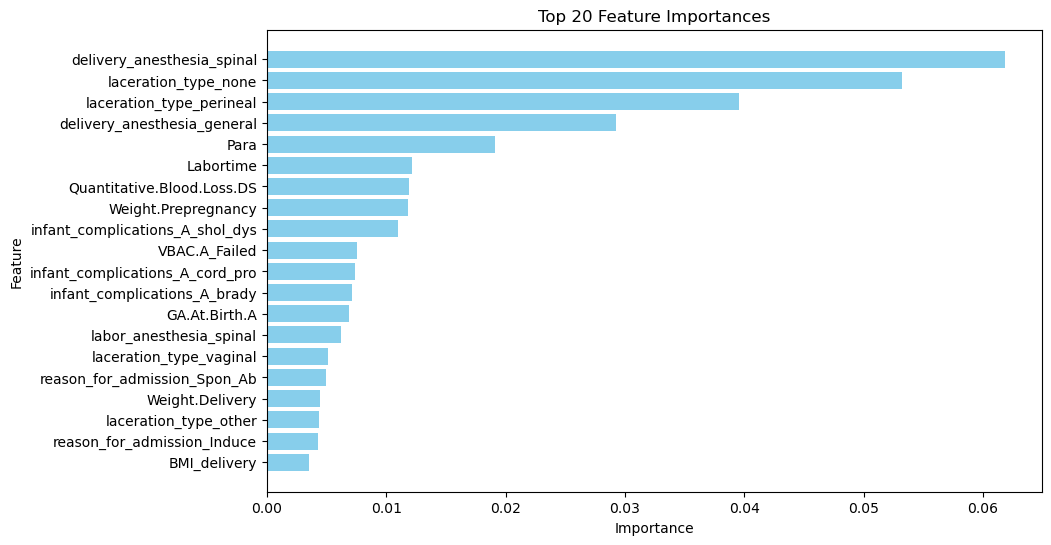

In [51]:
model3,importance3,features_i3,top_features_ml = models.run_Multinomial1(X_train, X_test, y_train, y_test)

The permutation importance for a multinomial logistic regression model provides an indication of how much each feature contributes to the model's predictive power. By permuting each feature and observing the change in performance, you can determine the importance of each feature. This method is model-agnostic and can be applied to any classifier.

In [52]:
coefficients3 = model3.coef_

# Get the intercepts
intercepts3 = model3.intercept_

In [53]:
# Print the coefficients with feature names
print("Coefficients:")

for i, class_coefficients in enumerate(coefficients3):
    feature_list = []
    print(f"\nClass {model3.classes_[i]} coefficients:")
    for feature, coef in zip(X_train.columns, class_coefficients):
        print(f"{feature}: {coef:.4f}")
        feature_list.append(feature)

print("\nIntercepts:")
for i, intercept in enumerate(intercepts3):
    print(f"Class {model3.classes_[i]} intercept: {intercept:.4f}")

Coefficients:

Class 0 coefficients:
Age: 0.3094
Gravida: -0.4229
Para: -0.1146
Number.of.Babies.In.Womb: 0.0477
Delivery.Year: -0.0132
Infant.Cord.Vessels.A: -0.1558
Infant.Length.A: -0.0303
Birthweight.A: -0.2843
GA.At.Birth.A: 0.3130
Weight.Prepregnancy: -0.5543
Weight.Gain.Pounds: -0.0862
OFC.At.Birth.Baby.A.In: -0.0510
Quantitative.Blood.Loss.DS: 0.3623
Weight.Delivery: 0.6354
BMI_delivery: -0.0690
BMI_prepregnancy: 0.2154
Labortime: 0.1383
delivery_anesthesia_epidural: 0.2834
delivery_anesthesia_spinal: 0.6569
delivery_anesthesia_local: -0.8908
delivery_anesthesia_pudenal: -0.1390
delivery_anesthesia_cse: 0.0887
delivery_anesthesia_general: 1.3407
delivery_anesthesia_intrathe: -0.1550
labor_anesthesia_epidural: -0.1757
labor_anesthesia_spinal: -0.5527
labor_anesthesia_cse: -0.2657
labor_anesthesia_general: 0.6276
labor_anesthesia_iv_sedation: 0.1622
laceration_type_none: 0.5371
laceration_type_vaginal: 0.5606
laceration_type_perineal: 1.0755
laceration_type_periuret: -0.3833
lace

In [56]:
coefficients3.shape

(3, 239)

In [55]:
len(feature_list)

239

In [57]:
coefficients3_imp = pd.DataFrame(coefficients3)
coefficients3_imp

,0,1,2,3,4,5,6,7,8,9,...,229,230,231,232,233,234,235,236,237,238
0,0.309439,-0.422943,-0.114597,0.047669,-0.013202,-0.155835,-0.030341,-0.284307,0.313040,-0.554341,...,-0.022572,0.139726,-0.006261,0.123277,-0.004879,-0.044002,0.004181,-0.026572,0.008343,0.066580
1,-0.466768,0.156501,0.904357,-0.170320,0.045315,0.017091,-0.216585,0.189195,-0.648440,-0.087734,...,0.026640,-0.084876,-0.000316,-0.201392,0.049524,0.033249,0.016400,-0.019856,0.015387,-0.007209
2,0.157329,0.266442,-0.789759,0.122651,-0.032112,0.138744,0.246926,0.095113,0.335399,0.642075,...,-0.004068,-0.054850,0.006577,0.078115,-0.044644,0.010754,-0.020581,0.046427,-0.023730,-0.059371


In [65]:
coeff_df = pd.DataFrame(coefficients3, columns=X_test.columns)
coeff_df = coeff_df.T

In [66]:
coeff_df.columns = ['emergency', 'vag', 'non-emergency']
coeff_df['max_col'] = coeff_df.idxmax(axis=1)

# Display the updated dataframe
print(coeff_df)

                               emergency       vag  non-emergency  \
Age                             0.309439 -0.466768       0.157329   
Gravida                        -0.422943  0.156501       0.266442   
Para                           -0.114597  0.904357      -0.789759   
Number.of.Babies.In.Womb        0.047669 -0.170320       0.122651   
Delivery.Year                  -0.013202  0.045315      -0.032112   
...                                  ...       ...            ...   
Provider.On.Admission_unknown  -0.044002  0.033249       0.010754   
Ethnicity_D                     0.004181  0.016400      -0.020581   
Ethnicity_H                    -0.026572 -0.019856       0.046427   
Ethnicity_O                     0.008343  0.015387      -0.023730   
Ethnicity_U                     0.066580 -0.007209      -0.059371   

                                     max_col  
Age                                emergency  
Gravida                        non-emergency  
Para                          

In [67]:
coeff_df.to_csv('../data/coef_df_ml_mlr.csv')

### data: mice

In [20]:
X_train, X_test, y_train, y_test = helpers.split_and_scale_data(features_mice, labels_mice)

In [21]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 8608, 2: 1815, 0: 361})
Counter({1: 3726, 2: 757, 0: 139})


In [17]:
X_train, y_train = helpers.perform_SMOTE(X_train, y_train)
print(Counter(y_train))

Counter({1: 8608, 2: 8608, 0: 8608})


/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Mean Accuracy: 0.938 (0.006)
Confusion Matrix:
[[  65   15   59]
 [   7 3669   50]
 [  27   81  649]]

Classification Report:
{'0': {'precision': 0.6565656565656566, 'recall': 0.4676258992805755, 'f1-score': 0.5462184873949579, 'support': 139}, '1': {'precision': 0.9745019920318725, 'recall': 0.9847020933977456, 'f1-score': 0.9795754905887064, 'support': 3726}, '2': {'precision': 0.8562005277044855, 'recall': 0.857331571994716, 'f1-score': 0.8567656765676568, 'support': 757}, 'accuracy': 0.9482907832107312, 'macro avg': {'precision': 0.8290893921006716, 'recall': 0.769886521557679, 'f1-score': 0.794186551517107, 'support': 4622}, 'weighted avg': {'precision': 0.9455648740903675, 'recall': 0.9482907832107312, 'f1-score': 0.946428875993755, 'support': 4622}}


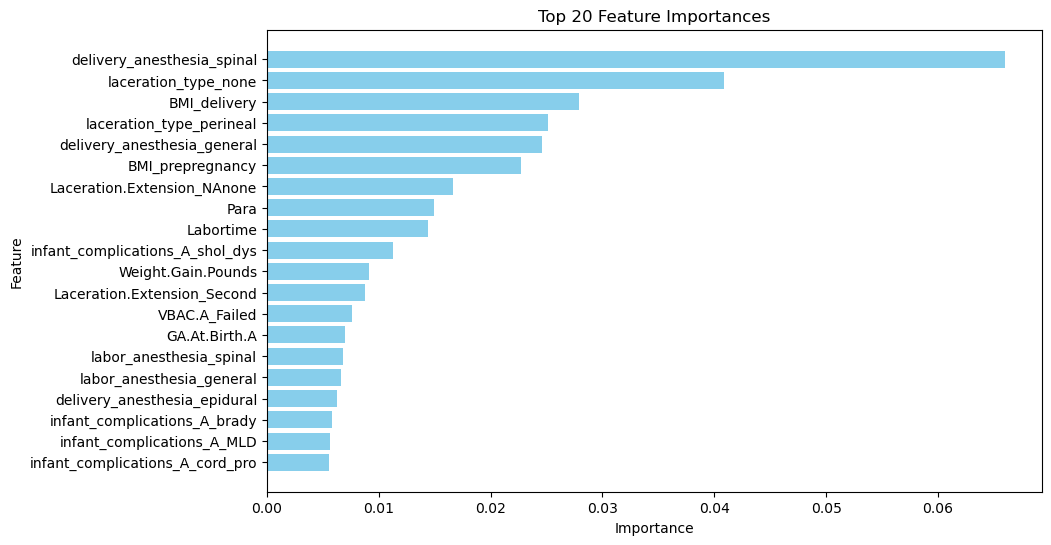

In [34]:
model4,importance4,features_i4,top_features_mice = run_Multinomial1(X_train, X_test, y_train, y_test)

In [35]:
y_pred_mice = model4.predict(X_test)

In [36]:
y_pred_mice_prob = model4.predict_proba(X_test)

In [42]:
from sklearn import metrics
def confusion_matrix2(y_true, y_pred):
    plt.figure(figsize = (16,8))
    unique_labels = np.unique(y_true)
    sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot = True,fmt='d',
                annot_kws={"size": 18},xticklabels = unique_labels, yticklabels = unique_labels, cmap = 'summer')
    plt.xlabel('Predicted Labels',fontsize=16)
    plt.ylabel('True Labels', fontsize=16)
    plt.xticks(fontsize=16)  # Change the size of x-tick labels
    plt.yticks(fontsize=16)
    plt.show()

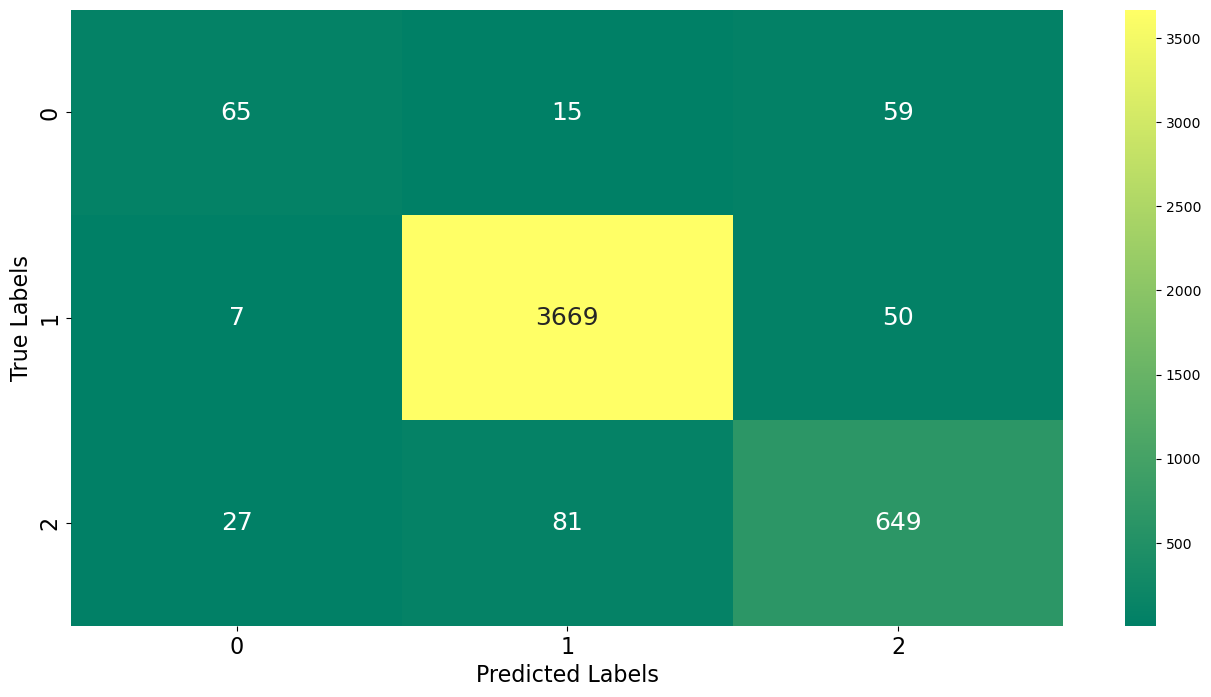

In [43]:
confusion_matrix2(y_test,y_pred_mice)

In [39]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred_mice))
print('Accuracy:', metric.accuracy(y_test, y_pred_mice))
print('Precision:', metric.macro_precision(y_test, y_pred_mice))
print('Recall:', metric.macro_recall(y_test, y_pred_mice))
print('F1:', metric.macro_f1(y_test, y_pred_mice))

AUC: {0: 0.7300208461381686, 1: 0.9387796181274443, 2: 0.9145648804346154}
Accuracy: 0.9482907832107312
Precision: 0.8290893894272181
Recall: 0.7698865199706684
F1: 0.7941860542355726


In [51]:

from tensorflow.keras.utils import to_categorical

In [56]:
# Create a dataframe with the observed and predicted counts
observed_counts = pd.DataFrame({'Observed': y_test})
predicted_counts = pd.DataFrame(y_pred_mice_prob, columns=['Class_0', 'Class_1', 'Class_2'])
predicted_counts['Predicted'] = y_pred_mice


In [58]:
from scipy.stats import chi2
# Calculate expected counts
expected_counts = predicted_counts.groupby('Predicted').sum().values

# Calculate observed counts
observed_counts = pd.get_dummies(observed_counts['Observed']).sum().values

# Compute Pearson Chi-Square statistic
chi_square_stat = ((observed_counts - expected_counts)**2 / expected_counts).sum()
p_value_chi_square = chi2.sf(chi_square_stat, df=len(observed_counts)-1)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [60]:
observed_counts

array([ 139, 3726,  757])

In [62]:
expected_counts

array([[ 216.03553422,   12.41856326,   40.54590252],
       [  35.7401598 , 3490.71952419,   91.54031602],
       [  80.50027502,   42.72185761,  611.77786737]])

In [47]:
result = permutation_importance(model4, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

In [48]:
result

{'importances_mean': array([ 5.27909996e-03,  4.67330160e-03,  2.27823453e-02,  1.01687581e-03,
        -6.49069667e-05,  1.29813933e-04,  3.28861965e-03,  8.65426222e-04,
         1.28515794e-02,  9.08697534e-04,  1.49286023e-03,  1.14668974e-03,
         8.58935526e-03,  1.10341843e-03,  3.54824751e-03,  5.36564258e-03,
         1.47338814e-02,  4.32713111e-04,  6.60752921e-02,  6.70705322e-04,
         3.09389875e-03,  1.47122458e-03,  3.17611424e-02,  3.24534833e-03,
         1.55776720e-03,  7.50757248e-03,  4.82475119e-03,  5.34400692e-03,
        -6.49069667e-05,  5.06057984e-02,  1.05581999e-02,  5.10817828e-02,
         3.05062743e-03,  2.37992211e-04,  8.11337084e-03,  8.58935526e-03,
         3.67806145e-03,  2.37992211e-04,  9.56295976e-03,  3.74296841e-03,
         1.06014712e-03,  2.20683687e-03,  1.11639983e-02,  5.62527045e-04,
         6.49069667e-04,  2.44482908e-03,  1.16832540e-03,  6.70705322e-03,
         3.31025530e-03, -3.46170489e-04,  1.81739507e-03,  4.327131

In [ ]:
importances = result.importances_mean
abs_importances = np.abs(importances)
indices = np.argsort(abs_importances)[::-1][:20]
top_20_features = [X_test_scaled.columns[i] for i in indices]
top_20_importances = importances[indices]

In [36]:
df_mice.shape

(15406, 90)

In [38]:
df_mice.to_csv('../data/df_mice_emergency.csv')

####  complete